## CELL 1 — Markdown (Detailed explanation for Notebook 06)

### NOTEBOOK 06 — Baseline Agreed Curve + Optimization (Dam Optimization Engine)

#### Why this notebook exists

Up to Notebook 05, we built a physically-based **daily lake water-balance simulator** driven by:

* **Rainfall (CHIRPS)** over the lake (mm/day)
* **Evaporation** from the lake surface (mm/day)
* **Total tributary inflow** (Qin, m³/s) reconstructed and aggregated (Notebook 04)
* **Observed outflow at Jinja** (Qout, m³/s)
* **Hypsometry from bathymetry raster**: stage → area and stage → storage (Notebook 05)
* **Calibrated parameters**:

  * `level_offset_m` (datum alignment)
  * `k_gw` (groundwater loss multiplier, calibratable)
  * `beta_inflow` (inflow scaling, calibratable)
  * `alpha_storage` / `alpha_storage_physical` (storage scaling, physically constrained)

Now, Notebook 06 upgrades the project from “lake simulation” to **dam operations simulation and optimization**.

---

## 1) Main idea: Lake + Dam as one controlled system

A dam policy can be written as:

> **Outflow is a function of lake level**:


 
Q 
out
​
 =f(H)

Where:

* (H) = lake level (stage) at Jinja
* (Q_{out}) = discharge released downstream (m³/s)

Once we define a dam policy function (f(\cdot)), we can simulate:

* future lake level trajectories
* flood risk outcomes
* operational stability (ramping)
* hydropower release performance

---

## 2) Part A — Baseline “Agreed Curve” reconstruction

Lake Victoria operations historically follow an “Agreed Curve” policy, which approximates a natural relationship between lake level and outflow.

We reconstruct the curve from historical level/outflow data using a power-law form:

$$Q = a \cdot \max(H - H_0, 0)^b$$


Where:

* (a) = scaling parameter
* (H_0) = level threshold below which outflow tends to near-zero (or minimal)
* (b) = exponent controlling curve steepness

### What we do:

1. We merge historical `Water_levels_at_Jinja.csv` and `Victoria_Nile_Out_Flows.csv`
2. Fit the parameters ((a, H_0, b)) using nonlinear regression
3. Save:

* fitted curve parameters table
* scatter + fitted curve plot

This becomes our **baseline “business-as-usual” dam policy**.

---

## 3) Part B — Baseline simulation (Agreed Curve policy simulation)

Once we have the fitted curve:

$$[
Q_{out}(t) = f(H_{sim}(t))
]$$

But since:

* (Q_{out}) depends on (H)
* and (H) depends on (Q_{out})

…we run a **two-pass policy simulation**:

1. First-pass: estimate outflow from initial levels
2. Second-pass: compute outflow using simulated levels and re-run

### Operational constraints applied

To keep the policy realistic, we apply constraints such as:

* **Minimum outflow**: $$(Q_{min})$$
* **Maximum outflow**: $$(Q_{max})$$
* **Ramping limit**: $$(|Q_t - Q_{t-1}| \leq \Delta Q_{max})$$

This prevents the optimizer (or baseline) from using physically impossible releases.

---

## 4) Part C — Optimization engine (Rule Curve + NSGA-II)

The Agreed Curve is only one possible policy.
We want to explore policies that reduce flood risk and improve performance.

So we define a **Rule Curve policy**:


$$Q_{out} = f(H)$$


…but instead of a single equation, we represent it as a **piecewise-linear curve** using 4 knots:

* Pick 4 important level points: (H_1, H_2, H_3, H_4)
* Optimize releases: (Q_1, Q_2, Q_3, Q_4)

Then:
[
Q(H) = \text {linear interpolation through knots}
]

This gives a flexible but still interpretable policy.

---

## 5) What exactly gets optimized (objectives)

We use **multi-objective optimization** because real dam operations must balance trade-offs.

### Objective 1 — Flood risk minimization

We penalize how much simulated lake level exceeds a flood threshold:

$$F_1 = \mathbb{E} [\max(H_{sim} - H_{flood}, 0)^2]$$

Lower is better.

### Objective 2 — Hydropower-friendly releases

We penalize deviation from a preferred discharge band / target:

$$F_2 = \mathbb{E} [(Q_{out} - Q_{target})^2]$$


Lower is better.

### Objective 3 — Smooth operations (no violent changes)

We penalize rapid changes in releases:

$$F_3 = \mathbb{E} [(Q_t - Q_{t-1})^2]$$


Lower is better.

---

## 6) Hard constraint enforced during optimization

We also enforce a safety constraint:

$$\max(H_{sim}) \le H_{max}$$

This prevents “unsafe solutions” even if they look good on objectives.

---

## 7) Key outputs saved by Notebook 06

This notebook saves key artifacts for the thesis and for Notebook 07:

### Tables

* `06_agreed_curve_fitted_params.csv`
* `06_baseline_vs_observed_metrics.csv`
* `06_optimization_pareto_solutions.csv`
* `06_optimization_best_compromise.csv`

### Figures

* `06_agreed_curve_fit_scatter.png`
* `06_baseline_level_timeseries.png`
* `06_pareto_front.png`
* `06_optimized_vs_baseline_levels.png`
* `06_optimized_vs_baseline_outflows.png`

### Processed simulations

* `06_baseline_agreedcurve_sim.csv`
* `06_optimized_rulecurve_sim.csv`

---

## 8) How Notebook 06 connects to Notebook 07

Notebook 07 will take the saved outputs and compute high-level decision metrics:

* flood events (days above thresholds, peak levels)
* release reliability (meeting hydropower targets)
* robustness and trade-off interpretation
* final “recommended policy” narrative for Chapter 4/5

So Notebook 06 is the **engine**, and Notebook 07 is the **evaluation + reporting layer**.




### *CELL 2 — Imports + paths*

In [1]:
from __future__ import annotations

import warnings
warnings.filterwarnings("ignore")

from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

# Optimization (install if missing: pip install pymoo)
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.termination import get_termination

In [2]:
# Paths
PROJECT_DIR = Path.cwd().parents[0]  # repo root if notebook is in /notebooks
DATA_RAW = PROJECT_DIR / "data" / "raw"
DATA_PROCESSED = PROJECT_DIR / "data" / "processed" 
DATA_PROCESSED_2 = PROJECT_DIR / "data" / "processed" / "hypsometry"

FIG_DIR = PROJECT_DIR / "outputs" / "figures"
TAB_DIR = PROJECT_DIR / "outputs" / "tables"
FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_DIR:", PROJECT_DIR)

PROJECT_DIR: c:\Users\Nelson\Downloads\LakeVictoria_Optimization


### *CELL 3 — Constants + helpers (date parsing, metrics)*
**Your outflow/evap files show mixed date formatting** `(e.g., 01/01/1956 and 1/13/1956).`

*This helper picks the parsing that yields the fewest NaTs.*

In [3]:
DT_SECONDS = 86400.0  # daily

def parse_mixed_date(s: pd.Series) -> pd.DatetimeIndex:
    d1 = pd.to_datetime(s, dayfirst=True, errors="coerce")
    d2 = pd.to_datetime(s, dayfirst=False, errors="coerce")
    # pick parsing with fewer missing
    if d2.isna().sum() < d1.isna().sum():
        return pd.DatetimeIndex(d2)
    return pd.DatetimeIndex(d1)


def rmse(a: np.ndarray, b: np.ndarray) -> float:
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    return float(np.sqrt(np.mean((a - b) ** 2)))


def nse(obs: np.ndarray, sim: np.ndarray) -> float:
    obs = np.asarray(obs, dtype=float)
    sim = np.asarray(sim, dtype=float)
    den = np.sum((obs - np.mean(obs)) ** 2)
    if den == 0:
        return np.nan
    return float(1 - np.sum((obs - sim) ** 2) / den)


def bias_mean(obs: np.ndarray, sim: np.ndarray) -> float:
    obs = np.asarray(obs, dtype=float)
    sim = np.asarray(sim, dtype=float)
    return float(np.mean(sim - obs))

### *CELL 4 — Bringing in the Simulator + Hypsometry functions (as-is)*

In [26]:
@dataclass
class SimParams:
    level_offset_m: float
    k_gw: float
    alpha_storage: float
    beta_inflow: float


_HYP_CACHE = {}

def _hyp_bounds(hyp_df: pd.DataFrame):
    # Cache sorted hypsometry; this removes repeated DataFrame sort work in long optimizations.
    key = id(hyp_df)
    cached = _HYP_CACHE.get(key)
    if cached is not None:
        return cached

    hyp_df_sorted = hyp_df.sort_values("stage_rel_m").drop_duplicates("stage_rel_m")
    h_min = float(hyp_df_sorted["stage_rel_m"].min())
    h_max = float(hyp_df_sorted["stage_rel_m"].max())
    s_min = float(hyp_df_sorted["storage_m3"].min())
    s_max = float(hyp_df_sorted["storage_m3"].max())
    a_min = float(hyp_df_sorted["area_m2"].min())
    value = (hyp_df_sorted, h_min, h_max, s_min, s_max, a_min)
    _HYP_CACHE[key] = value
    return value


def area_from_stage(stage_rel: np.ndarray, hyp_df: pd.DataFrame) -> np.ndarray:
    hyp_df, h_min, h_max, _, _, _ = _hyp_bounds(hyp_df)
    h = np.clip(np.asarray(stage_rel, dtype=float), h_min, h_max)
    # clamp outside domain
    return np.interp(h, hyp_df["stage_rel_m"].values, hyp_df["area_m2"].values,
                     left=float(hyp_df["area_m2"].iloc[0]),
                     right=float(hyp_df["area_m2"].iloc[-1]))


def storage_raster_from_stage(stage_rel: np.ndarray, hyp_df: pd.DataFrame) -> np.ndarray:
    hyp_df, h_min, h_max, _, _, _ = _hyp_bounds(hyp_df)
    h = np.clip(np.asarray(stage_rel, dtype=float), h_min, h_max)
    return np.interp(h, hyp_df["stage_rel_m"].values, hyp_df["storage_m3"].values,
                     left=float(hyp_df["storage_m3"].iloc[0]),
                     right=float(hyp_df["storage_m3"].iloc[-1]))


def stage_from_storage_raster(storage_raster: np.ndarray, hyp_df: pd.DataFrame) -> np.ndarray:
    hyp_df, h_min, h_max, s_min, s_max, _ = _hyp_bounds(hyp_df)
    s = np.clip(np.asarray(storage_raster, dtype=float), s_min, s_max)
    return np.interp(s, hyp_df["storage_m3"].values, hyp_df["stage_rel_m"].values,
                     left=h_min, right=h_max)


def groundwater_loss_m3_per_day(index: pd.DatetimeIndex, k_gw: float) -> pd.Series:
    base_m3_per_month = 0.09e9
    base_m3_per_day = base_m3_per_month / 30.0
    return pd.Series(base_m3_per_day * float(k_gw), index=index)


def simulate_lake_level(
    params: SimParams,
    hyp_df: pd.DataFrame,
    level_obs_m: pd.Series,
    rain_mm_day: pd.Series,
    evap_mm_day: pd.Series,
    qin_m3s: pd.Series,
    qout_m3s: pd.Series,
    index: pd.DatetimeIndex,
) -> pd.DataFrame:

    # --- prep / safety
    hyp_df, h_min, h_max, s_min, s_max, a_min = _hyp_bounds(hyp_df)

    # align + fill any missing forcing values (critical for NSGA stability)
    level_obs_m = level_obs_m.reindex(index).ffill().bfill()
    rain_mm_day = rain_mm_day.reindex(index).fillna(0.0)
    evap_mm_day = evap_mm_day.reindex(index).fillna(0.0)
    qin_m3s = qin_m3s.reindex(index).fillna(0.0)
    qout_m3s = qout_m3s.reindex(index).fillna(0.0)

    # initial stage (relative), clamped to hyp domain
    stage_rel0 = float(level_obs_m.iloc[0] - params.level_offset_m)
    stage_rel0 = float(np.clip(stage_rel0, h_min, h_max))

    # initial storage from raster/hyp curve
    S_r0 = float(storage_raster_from_stage(np.array([stage_rel0]), hyp_df)[0])
    S_true = float(params.alpha_storage) * S_r0

    # true storage must remain within physically representable range
    # (because inversions depend on raster storage domain)
    S_true_min = float(params.alpha_storage) * s_min
    S_true_max = float(params.alpha_storage) * s_max
    S_true = float(np.clip(S_true, S_true_min, S_true_max))

    n = len(index)
    qin_scaled_m3s = np.zeros(n, dtype=float)
    stage_rel = np.zeros(n, dtype=float)
    storage_true = np.zeros(n, dtype=float)
    area = np.zeros(n, dtype=float)

    vol_p_minus_e = np.zeros(n, dtype=float)
    vol_qin = np.zeros(n, dtype=float)
    vol_qout = np.zeros(n, dtype=float)
    vol_gw = np.zeros(n, dtype=float)
    dS = np.zeros(n, dtype=float)

    gw_m3_day = groundwater_loss_m3_per_day(index, params.k_gw).values

    for t, d in enumerate(index):
        # --- state at start of day: invert safely
        S_r = S_true / float(params.alpha_storage)
        S_r = float(np.clip(S_r, s_min, s_max))

        h0 = float(stage_from_storage_raster(np.array([S_r]), hyp_df)[0])
        h0 = float(np.clip(h0, h_min, h_max))

        A0 = float(area_from_stage(np.array([h0]), hyp_df)[0])
        # never allow zero/negative area
        A0 = float(max(A0, max(a_min, 1.0)))

        p_m = float(rain_mm_day.loc[d]) / 1000.0
        e_m = float(evap_mm_day.loc[d]) / 1000.0

        v_pe = (p_m - e_m) * A0

        qin_scaled = float(qin_m3s.loc[d]) * float(params.beta_inflow)
        v_in = qin_scaled * DT_SECONDS

        v_out = float(qout_m3s.loc[d]) * DT_SECONDS
        v_gw = float(gw_m3_day[t])

        delta_s = v_pe + v_in - v_out - v_gw

        # --- update + clamp storage to representable range
        S_true = float(S_true + delta_s)
        S_true = float(np.clip(S_true, S_true_min, S_true_max))

        # --- end of day: compute stored state consistently
        S_r1 = S_true / float(params.alpha_storage)
        S_r1 = float(np.clip(S_r1, s_min, s_max))

        h1 = float(stage_from_storage_raster(np.array([S_r1]), hyp_df)[0])
        h1 = float(np.clip(h1, h_min, h_max))

        A1 = float(area_from_stage(np.array([h1]), hyp_df)[0])
        A1 = float(max(A1, max(a_min, 1.0)))

        stage_rel[t] = h1
        storage_true[t] = S_true
        area[t] = A1

        qin_scaled_m3s[t] = qin_scaled
        vol_p_minus_e[t] = v_pe
        vol_qin[t] = v_in
        vol_qout[t] = v_out
        vol_gw[t] = v_gw
        dS[t] = delta_s

    level_sim = stage_rel + float(params.level_offset_m)

    out = pd.DataFrame(
        {
            "stage_rel_m": stage_rel,
            "storage_true_m3": storage_true,
            "area_m2": area,
            "level_sim_m": level_sim,
            "level_obs_m": level_obs_m.values,
            "vol_p_minus_e_m3d": vol_p_minus_e,
            "vol_qin_m3d": vol_qin,
            "vol_qout_m3d": vol_qout,
            "vol_gw_m3d": vol_gw,
            "dS_m3d": dS,
            "qin_scaled_m3s": qin_scaled_m3s,
        },
        index=index,
    )
    out.index.name = "date"
    return out

### *CELL 5 — Load Hypsometry (from Notebook 05 output)*
This assumes Notebook 05 saved: `data/processed/hypsometry/lv_stage_area_storage.csv`.

In [27]:
HYP_PATH = DATA_PROCESSED_2 / "lv_stage_area_storage.csv"
hyp = pd.read_csv(HYP_PATH)

required_cols = {"stage_rel_m", "area_m2", "storage_m3"}
if not required_cols.issubset(set(hyp.columns)):
    raise ValueError(f"Hypsometry missing cols. Found={hyp.columns}, required={required_cols}")

print("Loaded hypsometry:", HYP_PATH)
print("Area range (km2):", hyp["area_m2"].min() / 1e6, "to", hyp["area_m2"].max() / 1e6)
print("Storage range (km3):", hyp["storage_m3"].min() / 1e9, "to", hyp["storage_m3"].max() / 1e9)
hyp.head()

Loaded hypsometry: c:\Users\Nelson\Downloads\LakeVictoria_Optimization\data\processed\hypsometry\lv_stage_area_storage.csv
Area range (km2): 46026.56 to 57884.49
Storage range (km3): 1496.3138688118552 to 2830.7263442732055


,stage_rel_m,area_m2,storage_m3,dSdh_m2
0,-20.00,4.602656e+10,1.496314e+12,4.603932e+10
1,-19.95,4.605190e+10,1.498616e+12,4.605244e+10
2,-19.90,4.607921e+10,1.500919e+12,4.607878e+10
3,-19.85,4.610521e+10,1.503224e+12,4.610537e+10
4,-19.80,4.613165e+10,1.505530e+12,4.613209e+10


### *CELL 6 — Load core daily inputs (2001–2021)*

We load from the raw files and the processed inflow file.

**Rain:** `CHIRPS_daily_precipitation.csv` → Average_pcp_mm/day

**Evap:** `Lake_Victoria_Daily_Evaporation_2001_2023.csv` → Daily_Evaporation_mm/day

**Observed Level:** `Water_levels_at_Jinja.csv` → Water_Level_m/day

**Observed Outflow:** `Victoria_Nile_Out_Flows.csv` → Flow_cubic_metres/sec

**Qin total: your processed file:** `Qin_total_daily_2001_2021.csv` (from Notebook 04)

In [28]:
# --- Load raw ---
rain = pd.read_csv(DATA_RAW / "CHIRPS_daily_precipitation.csv")
evap = pd.read_csv(DATA_RAW / "Lake_Victoria_Daily_Evaporation_2001_2023.csv")
levels = pd.read_csv(DATA_RAW / "Water_levels_at_Jinja.csv")
outflows = pd.read_csv(DATA_RAW / "Victoria_Nile_Out_Flows.csv")

# --- Parse dates robustly ---
rain["Date"] = parse_mixed_date(rain["Date"])
evap["Date"] = parse_mixed_date(evap["Date"])
levels["Date"] = parse_mixed_date(levels["Date"])
outflows["Date"] = parse_mixed_date(outflows["Date"])

# --- Standardize names ---
rain = rain.rename(columns={"Average_pcp_mm/day": "rain_mm_day"}).set_index("Date").sort_index()
evap = evap.rename(columns={"Daily_Evaporation_mm/day": "evap_mm_day"}).set_index("Date").sort_index()
levels = levels.rename(columns={"Water_Level_m/day": "level_obs_m"}).set_index("Date").sort_index()
outflows = outflows.rename(columns={"Flow_cubic_metres/sec": "qout_obs_m3s"}).set_index("Date").sort_index()

# --- Qin (processed) ---
QIN_PATH = DATA_PROCESSED / "Qin_total_daily_2001_2021.csv"
qin_raw = pd.read_csv(QIN_PATH)

# Handle either:
# (A) columns = ["date","qin_m3s"] OR
# (B) first unnamed column is date, second column is values
if "date" in qin_raw.columns:
    qin_raw["date"] = pd.to_datetime(qin_raw["date"], errors="coerce")
    qin = qin_raw.set_index("date")
else:
    # try first col as date
    qin_raw.iloc[:, 0] = pd.to_datetime(qin_raw.iloc[:, 0], errors="coerce")
    qin = qin_raw.set_index(qin_raw.columns[0])

# Find value column
value_cols = [c for c in qin.columns if c.lower() not in ["date"]]
if len(value_cols) == 0:
    raise ValueError(f"Qin file has no value column. Columns={qin_raw.columns}")

qin = qin.rename(columns={value_cols[0]: "qin_m3s"}).sort_index()
qin = qin[["qin_m3s"]]

# --- Core period ---
START, END = "2001-01-01", "2021-04-27"
idx = pd.date_range(START, END, freq="D")

core = pd.DataFrame(index=idx)
core["rain_mm_day"] = rain["rain_mm_day"].reindex(idx)
core["evap_mm_day"] = evap["evap_mm_day"].reindex(idx)
core["level_obs_m"] = levels["level_obs_m"].reindex(idx)
core["qout_obs_m3s"] = outflows["qout_obs_m3s"].reindex(idx)
core["qin_m3s"] = qin["qin_m3s"].reindex(idx)

# quick checks
print("Core NA counts:\n", core.isna().sum())
core.head()

Core NA counts:
 rain_mm_day      0
evap_mm_day      0
level_obs_m      2
qout_obs_m3s    62
qin_m3s          0
dtype: int64


,rain_mm_day,evap_mm_day,level_obs_m,qout_obs_m3s,qin_m3s
2001-01-01,3.860586,4.67,11.69,1013.657,444.060046
2001-01-02,1.434765,4.53,11.70,1097.585,165.032384
2001-01-03,1.888148,5.08,11.70,1154.564,217.182355
2001-01-04,5.468835,4.25,11.69,1133.514,629.047275
2001-01-05,2.466247,2.44,11.70,1084.993,283.677573


### *CELL 7 — Load your best calibrated params from Notebook 05*

This expects `outputs/tables/05_lake_level_performance.csv` exists and has:

`level_offset_m`

`k_gw`

`alpha_storage_physical or alpha_storage`

`beta_inflow`

In [29]:
perf_path = TAB_DIR / "05_lake_level_performance.csv"
if not perf_path.exists():
    raise FileNotFoundError(f"Missing {perf_path}. Run Notebook 05 and ensure it saves performance table.")

perf = pd.read_csv(perf_path).iloc[0].to_dict()

level_offset_m = float(perf.get("level_offset_m"))
k_gw = float(perf.get("k_gw"))
beta_inflow = float(perf.get("beta_inflow", 1.0))

alpha_storage = perf.get("alpha_storage_physical", None)
if alpha_storage is None:
    alpha_storage = perf.get("alpha_storage", None)
if alpha_storage is None:
    raise ValueError("Performance table must contain alpha_storage_physical or alpha_storage.")

alpha_storage = float(alpha_storage)

params_best = SimParams(
    level_offset_m=level_offset_m,
    k_gw=k_gw,
    alpha_storage=alpha_storage,
    beta_inflow=beta_inflow,
)

params_best

SimParams(level_offset_m=11.71208628820527, k_gw=1.5, alpha_storage=1.0821216644719702, beta_inflow=2.298999806513798)

## PART A — Reconstruct Agreed Curve from historical data

### *CELL 8 — Prepare overlap dataset for fitting (level vs outflow)*

In [30]:
df_fit = levels.join(outflows, how="inner")
df_fit = df_fit.rename(columns={"level_obs_m": "level_m", "qout_obs_m3s": "qout_m3s"})
df_fit = df_fit.dropna()

print("Fitting data overlap:", df_fit.index.min(), "->", df_fit.index.max(), "n=", len(df_fit))
df_fit.head()

Fitting data overlap: 1956-08-14 00:00:00 -> 2021-04-27 00:00:00 n= 20158


,level_m,qout_m3s
Date,,
1956-08-14,10.95,501.811
1956-08-15,10.94,543.161
1956-08-16,10.94,543.562
1956-08-17,10.95,539.954
1956-08-18,10.93,535.894


### *CELL 9 — Define Agreed Curve functional form and fit parameters*

We fit:

**Q=a⋅max(H − $H_0$
​
 ,0) 
$^b$** 


In [31]:
def agreed_curve(h: np.ndarray, a: float, h0: float, b: float) -> np.ndarray:
    x = np.maximum(h - h0, 0.0)
    return a * (x ** b)

In [32]:
# Calibration window for "historical regime"
FIT_START, FIT_END = "1956-01-01", "1999-12-31"
cal = df_fit.loc[FIT_START:FIT_END].copy()

# Positive flows only
cal = cal[cal["qout_m3s"] > 0]

h = cal["level_m"].values.astype(float)
q = cal["qout_m3s"].values.astype(float)

# Initial guess + bounds
p0 = [50.0, np.percentile(h, 5), 2.0]
bounds = ([1e-6, h.min() - 2.0, 1.0],
          [1e5,  h.max(),     4.0])

popt, pcov = curve_fit(agreed_curve, h, q, p0=p0, bounds=bounds, maxfev=30000)
a_hat, h0_hat, b_hat = map(float, popt)

q_pred = agreed_curve(h, a_hat, h0_hat, b_hat)

fit_summary = pd.DataFrame([{
    "fit_start": FIT_START,
    "fit_end": FIT_END,
    "a": a_hat,
    "h0": h0_hat,
    "b": b_hat,
    "rmse_m3s": rmse(q, q_pred),
    "nse": nse(q, q_pred),
    "bias_m3s": bias_mean(q, q_pred),
}])

fit_summary.to_csv(TAB_DIR / "06_agreed_curve_fitted_params.csv", index=False)
fit_summary

,fit_start,fit_end,a,h0,b,rmse_m3s,nse,bias_m3s
0,1956-01-01,1999-12-31,187.789963,8.73,1.484624,132.251582,0.808856,-0.692153


### *CELL 10 — Plot Agreed Curve fit (save figure)*

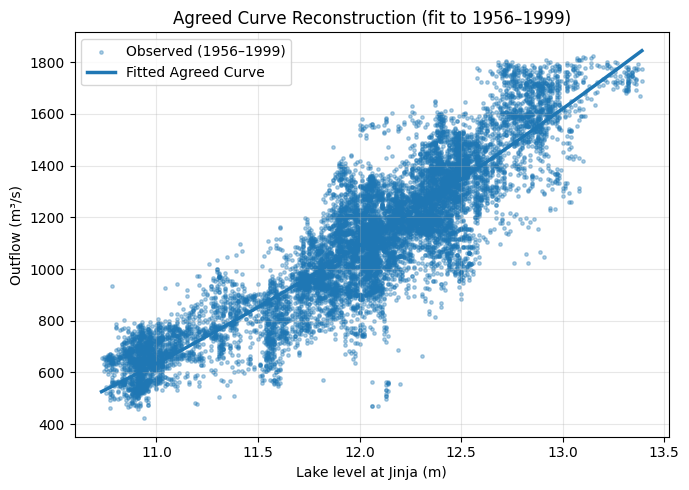

In [33]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(cal["level_m"], cal["qout_m3s"], s=6, alpha=0.35, label="Observed (1956–1999)")
h_grid = np.linspace(cal["level_m"].min(), cal["level_m"].max(), 250)
ax.plot(h_grid, agreed_curve(h_grid, a_hat, h0_hat, b_hat), linewidth=2.5, label="Fitted Agreed Curve")

ax.set_xlabel("Lake level at Jinja (m)")
ax.set_ylabel("Outflow (m³/s)")
ax.set_title("Agreed Curve Reconstruction (fit to 1956–1999)")
ax.grid(True, alpha=0.3)
ax.legend()

fig.tight_layout()
fig.savefig(FIG_DIR / "06_agreed_curve_fit_scatter.png", dpi=200)
plt.show()

## PART B — Baseline policy simulation (Agreed Curve drives outflows)

### *CELL 11 — Operational constraints*

In [34]:
Q_MIN = 200.0     # m3/s (edit if you have official minimum)
Q_MAX = 2500.0    # m3/s (edit if you have official maximum)
DQ_MAX = 200.0    # m3/s/day ramp limit (operational smoothness)

def apply_constraints(q: np.ndarray) -> np.ndarray:
    q = np.asarray(q, dtype=float)
    q = np.clip(q, Q_MIN, Q_MAX)

    q2 = q.copy()
    for t in range(1, len(q2)):
        dq = q2[t] - q2[t - 1]
        if dq > DQ_MAX:
            q2[t] = q2[t - 1] + DQ_MAX
        elif dq < -DQ_MAX:
            q2[t] = q2[t - 1] - DQ_MAX
    return q2

### *CELL 12 — The key patch: simulate with `“forced qout policy”`*

This function uses the simulate_lake_level() untouched by passing a qout series.

In [35]:
def simulate_with_forced_qout(
    params: SimParams,
    hyp_df: pd.DataFrame,
    core_df: pd.DataFrame,
    qout_forced_m3s: np.ndarray,
) -> pd.DataFrame:
    idx = core_df.index
    qout_series = pd.Series(qout_forced_m3s, index=idx, name="qout_m3s")

    return simulate_lake_level(
        params=params,
        hyp_df=hyp_df,
        level_obs_m=core_df["level_obs_m"],
        rain_mm_day=core_df["rain_mm_day"],
        evap_mm_day=core_df["evap_mm_day"],
        qin_m3s=core_df["qin_m3s"],
        qout_m3s=qout_series,
        index=idx,
    )

### *CELL 13 — Agreed Curve baseline: Qout computed from current simulated level*

**We compute daily releases dynamically:**

Start from the first observed level (storage initialization in your simulator)

Each day:

compute 
𝑄
𝑡
=
𝑓
(
𝐻
𝑠
𝑖
𝑚
,
𝑡
)
Q 
t
​
 =f(H 
sim,t
​
 )

enforce bounds + ramping

In [36]:
def simulate_agreed_curve_policy(
    params: SimParams,
    hyp_df: pd.DataFrame,
    core_df: pd.DataFrame,
) -> pd.DataFrame:
    idx = core_df.index
    q_policy = np.zeros(len(idx), dtype=float)

    # start from observed initial level
    h_prev = float(core_df["level_obs_m"].iloc[0])
    q_prev = float(core_df["qout_obs_m3s"].iloc[0]) if np.isfinite(core_df["qout_obs_m3s"].iloc[0]) else Q_MIN

    for t in range(len(idx)):
        q_raw = float(agreed_curve(np.array([h_prev]), a_hat, h0_hat, b_hat)[0])
        q_raw = float(np.clip(q_raw, Q_MIN, Q_MAX))

        # ramp constraint
        dq = q_raw - q_prev
        if dq > DQ_MAX:
            q_raw = q_prev + DQ_MAX
        elif dq < -DQ_MAX:
            q_raw = q_prev - DQ_MAX

        q_policy[t] = q_raw
        q_prev = q_raw

        # quick forward: approximate next h_prev using previous day's observed
        # (we will get actual simulated levels after running simulation once)
        # this is just to build initial q series; we will iterate 2 passes below.
        h_prev = float(core_df["level_obs_m"].iloc[t])

    # 1st pass simulation
    sim1 = simulate_with_forced_qout(params, hyp_df, core_df, q_policy)

    # 2nd pass (use simulated level to compute policy)
    q_policy2 = np.zeros(len(idx), dtype=float)
    q_prev = q_policy[0]
    for t in range(len(idx)):
        h_now = float(sim1["level_sim_m"].iloc[t])
        q_raw = float(agreed_curve(np.array([h_now]), a_hat, h0_hat, b_hat)[0])
        q_raw = float(np.clip(q_raw, Q_MIN, Q_MAX))

        dq = q_raw - q_prev
        if dq > DQ_MAX:
            q_raw = q_prev + DQ_MAX
        elif dq < -DQ_MAX:
            q_raw = q_prev - DQ_MAX

        q_policy2[t] = q_raw
        q_prev = q_raw

    sim2 = simulate_with_forced_qout(params, hyp_df, core_df, q_policy2)
    sim2["qout_policy_m3s"] = q_policy2
    return sim2

In [37]:
baseline = simulate_agreed_curve_policy(params_best, hyp, core)
baseline.head()

,stage_rel_m,storage_true_m3,area_m2,level_sim_m,level_obs_m,vol_p_minus_e_m3d,vol_qin_m3d,vol_qout_m3d,vol_gw_m3d,dS_m3d,qin_scaled_m3s,qout_policy_m3s
date,,,,,,,,,,,,
2001-01-01,-0.022795,2.748572e+12,5.788449e+10,11.689292,11.69,-4.685252e+07,8.820524e+07,8.123117e+07,4500000.0,-4.437845e+07,1020.893961,940.175582
2001-01-02,-0.026498,2.748340e+12,5.788449e+10,11.685588,11.70,-1.791661e+08,3.278097e+07,8.108018e+07,4500000.0,-2.319653e+08,379.409420,938.428041
2001-01-03,-0.030123,2.748113e+12,5.788449e+10,11.681963,11.70,-1.847587e+08,4.313971e+07,8.093212e+07,4500000.0,-2.270511e+08,499.302191,936.714340
2001-01-04,-0.028367,2.748223e+12,5.788449e+10,11.683720,11.69,7.055164e+07,1.249499e+08,8.100318e+07,4500000.0,1.099984e+08,1446.179564,937.536757
2001-01-05,-0.028808,2.748196e+12,5.788449e+10,11.683279,11.70,1.519280e+06,5.634789e+07,8.098505e+07,4500000.0,-2.761787e+07,652.174684,937.326922


### *CELL 14 — Baseline performance vs observed levels (save table + plot)*

In [38]:
obs = baseline["level_obs_m"].values
sim = baseline["level_sim_m"].values

baseline_metrics = pd.DataFrame([{
    "rmse_m": rmse(obs, sim),
    "nse": nse(obs, sim),
    "bias_mean_m": bias_mean(obs, sim),
    "policy": "agreed_curve_baseline",
    "a": a_hat,
    "h0": h0_hat,
    "b": b_hat,
}])

baseline_metrics.to_csv(TAB_DIR / "06_baseline_vs_observed_metrics.csv", index=False)
baseline_metrics

,rmse_m,nse,bias_mean_m,policy,a,h0,b
0,1.59856,-6.448889,-0.902274,agreed_curve_baseline,187.789963,8.73,1.484624


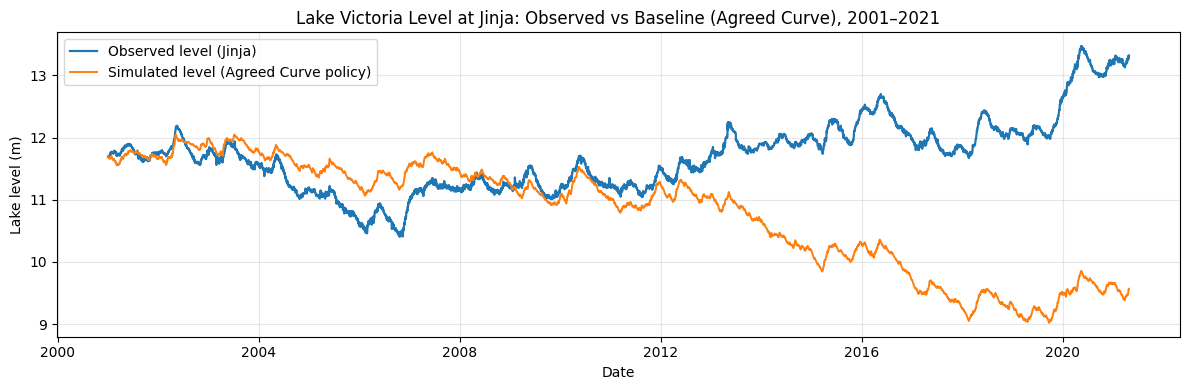

In [39]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(baseline.index, baseline["level_obs_m"], linewidth=1.6, label="Observed level (Jinja)")
ax.plot(baseline.index, baseline["level_sim_m"], linewidth=1.4, label="Simulated level (Agreed Curve policy)")
ax.set_title("Lake Victoria Level at Jinja: Observed vs Baseline (Agreed Curve), 2001–2021")
ax.set_xlabel("Date")
ax.set_ylabel("Lake level (m)")
ax.grid(True, alpha=0.3)
ax.legend()

fig.tight_layout()
fig.savefig(FIG_DIR / "06_baseline_level_timeseries.png", dpi=200)
plt.show()

## PART C — Optimization engine (NSGA-II rule curve policy)

### *CELL 15 — Define rule curve structure (piecewise-linear Q=f(H))*

We pick 4 level knots based on observed distribution in 2001–2021.


In [40]:
level_series = core["level_obs_m"].dropna()
H_knots = level_series.quantile([0.10, 0.40, 0.70, 0.95]).values.astype(float)
H_knots

array([11.07, 11.52, 11.92, 13.01])

In [41]:
def rulecurve_piecewise(level_arr: np.ndarray, q_knots: np.ndarray) -> np.ndarray:
    level_arr = np.asarray(level_arr, dtype=float)
    q_knots = np.asarray(q_knots, dtype=float)

    # Fill missing/invalid levels so interpolation always gets finite x-values
    level_filled = pd.Series(level_arr).ffill().bfill().to_numpy(dtype=float)
    if not np.isfinite(level_filled).all():
        level_filled = np.nan_to_num(level_filled, nan=float(np.nanmedian(H_knots)))

    q = np.interp(level_filled, H_knots, q_knots)
    q = np.clip(q, Q_MIN, Q_MAX)
    q = apply_constraints(q)
    q = np.nan_to_num(q, nan=Q_TARGET, posinf=Q_MAX, neginf=Q_MIN)
    return q

### *CELL 16 — Define objectives + constraint thresholds*

In [42]:
H_FLOOD = float(level_series.quantile(0.95))  # pragmatic flood threshold
H_MAX = 13.60                                 # hard cap (edit if you have official)
Q_TARGET = float(np.nanmedian(core["qout_obs_m3s"]))  # hydropower-friendly central value

print("H_FLOOD:", H_FLOOD, "H_MAX:", H_MAX, "Q_TARGET:", Q_TARGET)

H_FLOOD: 13.01 H_MAX: 13.6 Q_TARGET: 949.971


### *CELL 17 — Optimization problem class (3 objectives + 1 constraint)*

`Important:` for each candidate policy, we simulate levels via the water balance model.

In [43]:
BIG = 1e12  # big penalty value for optimization

# precompute hypsometry bounds once
S_MIN = float(hyp["storage_m3"].min())
S_MAX = float(hyp["storage_m3"].max())
H_MIN = float(hyp["stage_rel_m"].min())
H_MAX_HYP = float(hyp["stage_rel_m"].max())
A_MIN = float(hyp["area_m2"].min())  # should be >0

def simulate_levels_given_qout_policy(q_policy_m3s: np.ndarray) -> np.ndarray:
    """
    Always returns an array of length len(core) with finite floats.
    If sim fails or produces non-finite values, returns np.nan array.
    """
    q_policy_m3s = np.asarray(q_policy_m3s, dtype=float)

    # hard clip policy to allowed release bounds
    q_policy_m3s = np.clip(q_policy_m3s, Q_MIN, Q_MAX)

    try:
        sim_df = simulate_with_forced_qout(params_best, hyp, core, q_policy_m3s)
        lvl = sim_df["level_sim_m"].to_numpy(dtype=float)

        # If any NaN/inf, return NaNs
        if (lvl.shape[0] != len(core)) or (not np.isfinite(lvl).all()):
            return np.full(len(core), np.nan, dtype=float)

        return lvl

    except Exception:
        return np.full(len(core), np.nan, dtype=float)

def _is_finite_1d(arr: np.ndarray) -> bool:
    arr = np.asarray(arr, dtype=float)
    return arr.ndim == 1 and arr.size == len(core) and np.isfinite(arr).all()

class DamOptimizationProblem(Problem):
    def __init__(self):
        super().__init__(
            n_var=4,
            n_obj=3,
            n_constr=1,
            xl=np.full(4, Q_MIN),
            xu=np.full(4, Q_MAX),
        )

    def _evaluate(self, X, out, *args, **kwargs):
        F = np.zeros((X.shape[0], 3), dtype=float)
        G = np.zeros((X.shape[0], 1), dtype=float)

        for i, q_knots in enumerate(X):
            q_policy = rulecurve_piecewise(core["level_obs_m"].values, q_knots)
            level_sim = simulate_levels_given_qout_policy(q_policy)

            valid = _is_finite_1d(q_policy) and _is_finite_1d(level_sim)
            if not valid:
                # Keep values finite to avoid NaN propagation inside pymoo internals
                F[i, :] = [BIG, BIG, BIG]
                G[i, 0] = BIG
                continue

            # Obj 1: flood risk (quadratic exceedance)
            excess = np.maximum(level_sim - H_FLOOD, 0.0)
            f1 = float(np.mean(excess ** 2))

            # Obj 2: hydropower friendliness (deviation from target)
            f2 = float(np.mean((q_policy - Q_TARGET) ** 2))

            # Obj 3: smoothness (daily ramping penalty)
            dq = np.diff(q_policy)
            f3 = float(np.mean(dq ** 2))

            # Constraint: maximum level should not exceed H_MAX (<=0 is feasible)
            g1 = float(np.max(level_sim) - H_MAX)

            F[i, :] = [f1, f2, f3]
            G[i, 0] = g1

        out["F"] = np.nan_to_num(F, nan=BIG, posinf=BIG, neginf=BIG)
        out["G"] = np.nan_to_num(G, nan=BIG, posinf=BIG, neginf=BIG)

In [ ]:
# 1) rulecurve length check
test_q = rulecurve_piecewise(core["level_obs_m"].values, np.array([Q_TARGET]*4, dtype=float))
print("rulecurve length:", len(test_q), "expected:", len(core))

# 2) sim should now be finite (after hypsometry clipping patch)
lvl = simulate_levels_given_qout_policy(np.clip(np.asarray(test_q, float), Q_MIN, Q_MAX))
print("level_sim finite?", np.isfinite(lvl).all(), "min/max:", np.nanmin(lvl), np.nanmax(lvl))
print("NaN count:", np.isnan(lvl).sum())

### *CELL 18 — Run NSGA-II (Pareto optimization)*

In [48]:
problem = DamOptimizationProblem()
algorithm = NSGA2(pop_size=80)
termination = get_termination("n_gen", 120)

res = minimize(problem, algorithm, termination, seed=1, verbose=True)

if getattr(res, "X", None) is None:
    print("NSGA-II finished but res.X is None (likely all solutions invalid/penalized).")
else:
    print("NSGA-II done. Solutions:", len(res.X))

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       80 |      7 |  0.000000E+00 |  0.2348230322 |             - |             -
     2 |      160 |      2 |  0.000000E+00 |  0.000000E+00 |  1.0000000000 |         ideal
     3 |      240 |      4 |  0.000000E+00 |  0.000000E+00 |  0.7434706644 |         ideal
     4 |      320 |      4 |  0.000000E+00 |  0.000000E+00 |  0.5229727969 |         ideal
     5 |      400 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0076235795 |         ideal
     6 |      480 |      2 |  0.000000E+00 |  0.000000E+00 |  0.0046992592 |         ideal
     7 |      560 |      5 |  0.000000E+00 |  0.000000E+00 |  0.1579106348 |         ideal
     8 |      640 |      9 |  0.000000E+00 |  0.000000E+00 |  0.0025053139 |         ideal
     9 |      720 |      9 |  0.000000E+00 |  0.000000E+00 |  0.8554955719 |         nadir
    10 |      800 |     11 |  0.000000E+00 |  0.000000E+00 |  0.3258126670 |         nadir

In [45]:
import time
problem = DamOptimizationProblem()
X_test = np.random.uniform(Q_MIN, Q_MAX, size=(80, 4))
t0 = time.time()
out = {}
problem._evaluate(X_test, out)
elapsed = time.time() - t0
print("80 evals took", elapsed, "sec")
print("Estimated 120 generations (pop=80):", elapsed * 120, "sec")


80 evals took 128.29305338859558 sec
Estimated 120 generations (pop=80): 15395.16640663147 sec


Save the Pareto Solutions

In [49]:
sol = pd.DataFrame(res.X, columns=[f"Q_knot_{i+1}" for i in range(4)])
sol["F_flood"] = res.F[:, 0]
sol["F_power"] = res.F[:, 1]
sol["F_smooth"] = res.F[:, 2]
sol["g_max_level"] = res.G[:, 0]

sol.to_csv(TAB_DIR / "06_optimization_pareto_solutions.csv", index=False)
sol.head()

,Q_knot_1,Q_knot_2,Q_knot_3,Q_knot_4,F_flood,F_power,F_smooth,g_max_level
0,1027.262180,1027.237721,1027.643603,1028.566127,0.000000e+00,6017.526952,0.000148,-0.843939
1,949.590719,950.026213,949.227945,952.162925,6.413767e-03,0.446267,0.000983,-0.048705
2,1005.796596,968.470193,1020.252925,993.919848,2.218540e-07,2703.899383,2.450867,-0.564426
3,949.660584,950.077558,949.227945,952.162925,6.402247e-03,0.431589,0.001020,-0.049033
4,1025.522513,1027.237721,1027.643603,1028.566127,0.000000e+00,5944.646033,0.002082,-0.839068


### *CELL 19 — Plot Pareto front*

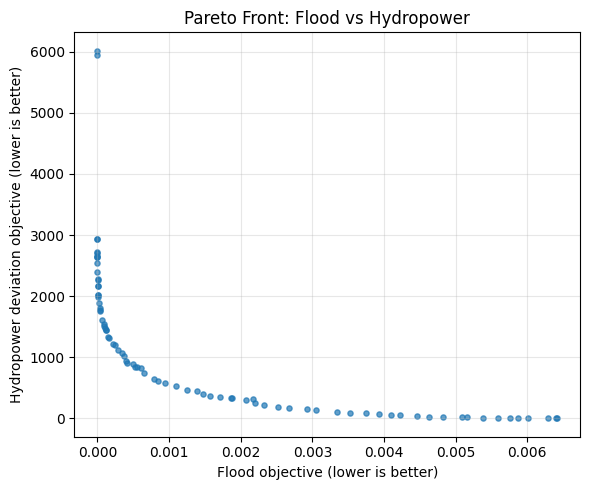

In [50]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(sol["F_flood"], sol["F_power"], s=14, alpha=0.7)
ax.set_xlabel("Flood objective (lower is better)")
ax.set_ylabel("Hydropower deviation objective (lower is better)")
ax.set_title("Pareto Front: Flood vs Hydropower")
ax.grid(True, alpha=0.3)
fig.tight_layout()
fig.savefig(FIG_DIR / "06_pareto_front.png", dpi=200)
plt.show()

### *CELL 20 — Select “best compromise” solution + compare to baseline*

In [52]:
def select_best_compromise(df: pd.DataFrame) -> pd.Series:
    cols = ["F_flood", "F_power", "F_smooth"]
    Z = df[cols].copy()
    Z = (Z - Z.min()) / (Z.max() - Z.min() + 1e-12)
    score = Z.sum(axis=1)  # equal weights
    return df.loc[score.idxmin()]

best = select_best_compromise(sol)
best_df = best.to_frame().T
best_df.to_csv(TAB_DIR / "06_optimization_best_compromise.csv", index=False)
best_df

,Q_knot_1,Q_knot_2,Q_knot_3,Q_knot_4,F_flood,F_power,F_smooth,g_max_level
73,968.258617,978.289599,977.878432,969.456474,0.000851,609.669839,0.069848,-0.29973


> Simulate optimized:

In [54]:
q_knots_best = best[[f"Q_knot_{i+1}" for i in range(4)]].values.astype(float)
q_opt = rulecurve_piecewise(core["level_obs_m"].values, q_knots_best)

opt_df = simulate_with_forced_qout(params_best, hyp, core, q_opt)
opt_df["qout_policy_m3s"] = q_opt
opt_df.head()

,stage_rel_m,storage_true_m3,area_m2,level_sim_m,level_obs_m,vol_p_minus_e_m3d,vol_qin_m3d,vol_qout_m3d,vol_gw_m3d,dS_m3d,qin_scaled_m3s,qout_policy_m3s
date,,,,,,,,,,,,
2001-01-01,-0.022847,2.748569e+12,5.788449e+10,11.689239,11.69,-4.685252e+07,8.820524e+07,8.450912e+07,4500000.0,-4.765640e+07,1020.893961,978.114853
2001-01-02,-0.026605,2.748334e+12,5.788449e+10,11.685481,11.70,-1.791661e+08,3.278097e+07,8.450824e+07,4500000.0,-2.353934e+08,379.409420,978.104573
2001-01-03,-0.030287,2.748103e+12,5.788449e+10,11.681799,11.70,-1.847587e+08,4.313971e+07,8.450824e+07,4500000.0,-2.306272e+08,499.302191,978.104573
2001-01-04,-0.028587,2.748209e+12,5.788449e+10,11.683499,11.69,7.055164e+07,1.249499e+08,8.450912e+07,4500000.0,1.064924e+08,1446.179564,978.114853
2001-01-05,-0.029084,2.748178e+12,5.788449e+10,11.683002,11.70,1.519280e+06,5.634789e+07,8.450824e+07,4500000.0,-3.114106e+07,652.174684,978.104573


### *CELL 21 — Plots: Optimized vs Baseline (levels + outflows)*

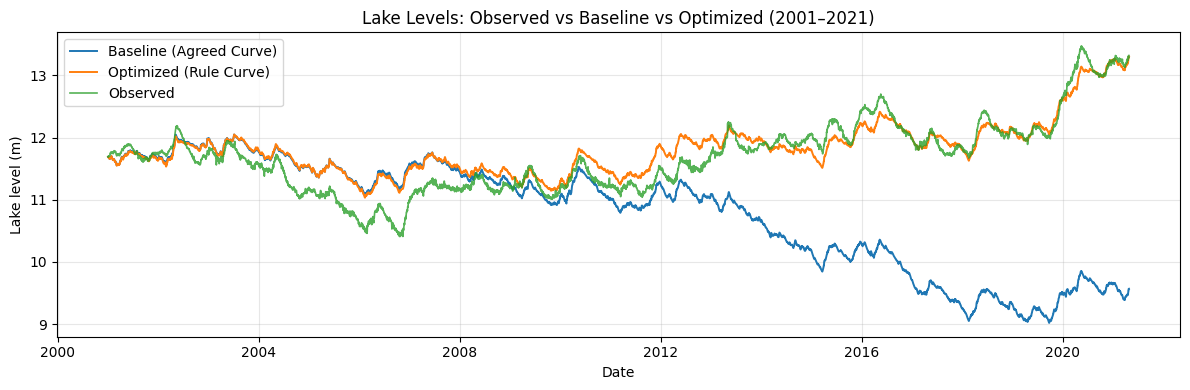

In [55]:
# Levels
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(baseline.index, baseline["level_sim_m"], linewidth=1.4, label="Baseline (Agreed Curve)")
ax.plot(opt_df.index, opt_df["level_sim_m"], linewidth=1.4, label="Optimized (Rule Curve)")
ax.plot(core.index, core["level_obs_m"], linewidth=1.2, alpha=0.8, label="Observed")

ax.set_title("Lake Levels: Observed vs Baseline vs Optimized (2001–2021)")
ax.set_xlabel("Date")
ax.set_ylabel("Lake level (m)")
ax.grid(True, alpha=0.3)
ax.legend()

fig.tight_layout()
fig.savefig(FIG_DIR / "06_optimized_vs_baseline_levels.png", dpi=200)
plt.show()

In [ ]:
# Levels
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(baseline.index, baseline["level_sim_m"], linewidth=1.4, label="Baseline (Agreed Curve)")
ax.plot(opt_df.index, opt_df["level_sim_m"], linewidth=1.4, label="Optimized (Rule Curve)")
ax.plot(core.index, core["level_obs_m"], linewidth=1.2, alpha=0.8, label="Observed")

ax.set_title("Lake Levels: Observed vs Baseline vs Optimized (2001–2021)")
ax.set_xlabel("Date")
ax.set_ylabel("Lake level (m)")
ax.grid(True, alpha=0.3)
ax.legend()

fig.tight_layout()
fig.savefig(FIG_DIR / "06_optimized_vs_baseline_levels.png", dpi=200)
plt.show()

### *CELL 20 — Save simulation outputs for Notebook 07*

In [ ]:
baseline_path = DATA_PROCESSED / "06_baseline_agreedcurve_sim.csv"
opt_path = DATA_PROCESSED / "06_optimized_rulecurve_sim.csv"

baseline.to_csv(baseline_path, index=True)
opt_df.to_csv(opt_path, index=True)

print("Saved baseline:", baseline_path)
print("Saved optimized:", opt_path)

$x^2$